In [1]:
import os
from dotenv import load_dotenv
load_dotenv()

GOOGLE_API_KEY                     = os.getenv("GOOGLE_API_KEY")
TAVILY_API_KEY                     = os.getenv("TAVILY_API_KEY")
GROQ_API_KEY                       = os.getenv("GROQ_API_KEY")
LANGSMITH_API_KEY                  = os.getenv("LANGSMITH_API_KEY")
LANGCHAIN_PROJECT                  = "langchain-agent"
SERPER_API_KEY                     = os.getenv("SERPER_API_KEY")

os.environ["GOOGLE_API_KEY"]       = GOOGLE_API_KEY
os.environ["GROQ_API_KEY"]         = GROQ_API_KEY
os.environ["LANGSMITH_API_KEY"]    = LANGSMITH_API_KEY
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGSMITH_ENDPOINT"]   = "https://api.smith.langchain.com"
os.environ["LANGCHAIN_PROJECT"]    = LANGCHAIN_PROJECT
os.environ["SERPER_API_KEY"]       = SERPER_API_KEY

In [2]:
from typing import Annotated, Literal, Sequence, TypedDict
from langchain import hub
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field
from langgraph.graph.message import add_messages
from langgraph.prebuilt import tools_condition
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.vectorstores import Chroma
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain.tools.retriever import create_retriever_tool
from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import ToolNode

C:\Users\User\anaconda3\envs\Cart_2.0\Lib\site-packages\IPython\core\interactiveshell.py:3577: LangChainDeprecationWarning: As of langchain-core 0.3.0, LangChain uses pydantic v2 internally. The langchain_core.pydantic_v1 module was a compatibility shim for pydantic v1, and should no longer be used. Please update the code to import from Pydantic directly.

For example, replace imports like: `from langchain_core.pydantic_v1 import BaseModel`
with: `from pydantic import BaseModel`
or the v1 compatibility namespace if you are working in a code base that has not been fully upgraded to pydantic 2 yet. 	from pydantic.v1 import BaseModel

  exec(code_obj, self.user_global_ns, self.user_ns)
USER_AGENT environment variable not set, consider setting it to identify your requests.


In [3]:
from langchain_huggingface import HuggingFaceEmbeddings
embeddings=HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")
from langchain_groq import ChatGroq
llm=ChatGroq(model_name="Gemma2-9b-It")

OSError: sentence-transformers/all-MiniLM-L6-v2 is not a local folder and is not a valid model identifier listed on 'https://huggingface.co/models'
If this is a private repository, make sure to pass a token having permission to this repo either by logging in with `huggingface-cli login` or by passing `token=<your_token>`

In [ ]:
llm.invoke("hello how are you?")

In [5]:
url= "https://lilianweng.github.io/posts/2023-06-23-agent/"

In [6]:
WebBaseLoader(url).load()

[Document(metadata={'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/', 'title': "LLM Powered Autonomous Agents | Lil'Log", 'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, thereby improving the quality of final resu

In [7]:
WebBaseLoader(url).load()[0].metadata

{'source': 'https://lilianweng.github.io/posts/2023-06-23-agent/',
 'title': "LLM Powered Autonomous Agents | Lil'Log",
 'description': 'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, thereby improving the quality of final results.\n\n\nMemory\

In [8]:
WebBaseLoader(url).load()[0].metadata["description"]

'Building agents with LLM (large language model) as its core controller is a cool concept. Several proof-of-concepts demos, such as AutoGPT, GPT-Engineer and BabyAGI, serve as inspiring examples. The potentiality of LLM extends beyond generating well-written copies, stories, essays and programs; it can be framed as a powerful general problem solver.\nAgent System Overview\nIn a LLM-powered autonomous agent system, LLM functions as the agent’s brain, complemented by several key components:\n\nPlanning\n\nSubgoal and decomposition: The agent breaks down large tasks into smaller, manageable subgoals, enabling efficient handling of complex tasks.\nReflection and refinement: The agent can do self-criticism and self-reflection over past actions, learn from mistakes and refine them for future steps, thereby improving the quality of final results.\n\n\nMemory\n\nShort-term memory: I would consider all the in-context learning (See Prompt Engineering) as utilizing short-term memory of the model 

In [9]:
urls = [
    "https://lilianweng.github.io/posts/2023-06-23-agent/",
    "https://lilianweng.github.io/posts/2023-03-15-prompt-engineering/",
]

In [10]:

docs = [WebBaseLoader(url).load() for url in urls]

In [29]:
#docs

In [16]:
docs_list = [item for sublist in docs for item in sublist]

In [18]:
text_splitter=RecursiveCharacterTextSplitter.from_tiktoken_encoder(chunk_size=100, chunk_overlap=25)

In [19]:
doc_splits=text_splitter.split_documents(docs_list)

In [21]:
len(doc_splits)

284

In [22]:
vectorstore=Chroma.from_documents(
    documents=doc_splits,
    collection_name="rag-chrome",
    embedding=embeddings
    
)

In [23]:
retriever=vectorstore.as_retriever()

In [24]:
retriever_tool=create_retriever_tool(
    retriever,
    "retrieve_blog_posts",
    "Search and return information about Lilian Weng blog posts on LLM agents, prompt engineering, and adversarial attacks on LLMs.You are a specialized assistant. Use the 'retriever_tool' **only** when the query explicitly relates to LangChain blog data. For all other queries, respond directly without using any tool. For simple queries like 'hi', 'hello', or 'how are you', provide a normal response.",
    )

In [25]:
tools=[retriever_tool]

In [26]:
retrieve=ToolNode([retriever_tool])

In [27]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]

In [28]:
def ai_assistant(state:AgentState):
    print("---CALL AGENT---")
    messages = state['messages']
    
    if len(messages)>1:
        last_message = messages[-1]
        question = last_message.content
        prompt=PromptTemplate(
        template="""You are a helpful assistant whatever question has been asked to find out that in the given question and answer.
                        Here is the question:{question}
                        """,
                        input_variables=["question"]
                        )
            
        chain = prompt | llm
    
        response=chain.invoke({"question": question})
        return {"messages": [response]}
    else:
        llm_with_tool = llm.bind_tools(tools)
        response = llm_with_tool.invoke(messages)
        #response=handle_query(messages)
        return {"messages": [response]}

In [31]:
class grade(BaseModel):
    binary_score:str=Field(description="Relevance score 'yes' or 'no'")

In [32]:
def grade_documents(state:AgentState)->Literal["Output_Generator", "Query_Rewriter"]:
    llm_with_structure_op=llm.with_structured_output(grade)
    
    prompt=PromptTemplate(
        template="""You are a grader deciding if a document is relevant to a user’s question.
                    Here is the document: {context}
                    Here is the user’s question: {question}
                    If the document talks about or contains information related to the user’s question, mark it as relevant. 
                    Give a 'yes' or 'no' answer to show if the document is relevant to the question.""",
                    input_variables=["context", "question"]
                    )
    chain = prompt | llm_with_structure_op
    
    messages = state["messages"]
    last_message = messages[-1]
    question = messages[0].content
    docs = last_message.content
    scored_result = chain.invoke({"question": question, "context": docs})
    score = scored_result.binary_score

    if score == "yes":
        print("---DECISION: DOCS RELEVANT---")
        return "generator" #this should be a node name
    else:
        print("---DECISION: DOCS NOT RELEVANT---")
        return "rewriter" #this should be a node name

In [30]:
hub.pull("rlm/rag-prompt").pretty_print()

================================ Human Message =================================

You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.
Question: {question} 
Context: {context} 
Answer:


In [33]:
def generate(state:AgentState):
    print("---GENERATE---")
    messages = state["messages"]

    question = messages[0].content
    
    last_message = messages[-1]
    docs = last_message.content
    
    prompt = hub.pull("rlm/rag-prompt")
    
    rag_chain = prompt | llm

    response = rag_chain.invoke({"context": docs, "question": question})
    print(f"this is my response:{response}")
    
    return {"messages": [response]}

In [34]:
from langchain_core.messages import  HumanMessage
def rewrite(state:AgentState):
    print("---TRANSFORM QUERY---")
    messages = state["messages"]
    question = messages[0].content
    
    message = [HumanMessage(content=f"""Look at the input and try to reason about the underlying semantic intent or meaning. 
                    Here is the initial question: {question} 
                    Formulate an improved question: """)
       ]
    response = llm.invoke(message)
    return {"messages": [response]}

In [35]:
workflow=StateGraph(AgentState)
workflow.add_node("My_Ai_Assistant",ai_assistant)
workflow.add_node("Vector_Retriever", retrieve) 
workflow.add_node("Output_Generator", generate)
workflow.add_node("Query_Rewriter", rewrite) 

In [36]:
workflow.add_edge(START,"My_Ai_Assistant")

In [37]:
workflow.add_conditional_edges("My_Ai_Assistant",
                            tools_condition,
                            {"tools": "Vector_Retriever",
                                END: END,})

In [38]:
workflow.add_conditional_edges("Vector_Retriever",
                            grade_documents,
                            {"generator": "Output_Generator",
                            "rewriter": "Query_Rewriter"
                            }
                            )

In [39]:

workflow.add_edge("Output_Generator", END)

In [40]:
workflow.add_edge("Query_Rewriter", "My_Ai_Assistant")

In [41]:
app=workflow.compile()

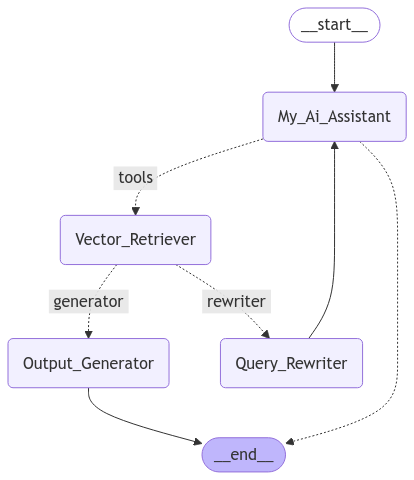

In [42]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [43]:
app.invoke({"messages":["What is a Autonomous Agent?"]})

---CALL AGENT---
---DECISION: DOCS RELEVANT---
---GENERATE---
this is my response:content='An Autonomous Agent is an intelligent system that can operate independently to achieve specific goals.  \n\nIt uses a large language model (LLM) as its core, along with other components like planning and self-reflection mechanisms.  LLM-powered autonomous agents are designed to solve problems and perform tasks autonomously. \n' additional_kwargs={} response_metadata={'token_usage': {'completion_tokens': 66, 'prompt_tokens': 338, 'total_tokens': 404, 'completion_time': 0.12, 'prompt_time': 0.010537168, 'queue_time': 0.022762820000000003, 'total_time': 0.130537168}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'stop', 'logprobs': None} id='run-75ca325f-f1ae-49c7-9d3f-09f4d641ea12-0' usage_metadata={'input_tokens': 338, 'output_tokens': 66, 'total_tokens': 404}


{'messages': [HumanMessage(content='What is a Autonomous Agent?', additional_kwargs={}, response_metadata={}, id='009cd033-1d19-4a7e-903d-2d18d7c453aa'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_p8ca', 'function': {'arguments': '{"query":"Autonomous Agent"}', 'name': 'retrieve_blog_posts'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 85, 'prompt_tokens': 1039, 'total_tokens': 1124, 'completion_time': 0.154545455, 'prompt_time': 0.04205344, 'queue_time': 0.024277988, 'total_time': 0.196598895}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-0e2da2a2-7978-4f92-90d7-a2b0db5a4b27-0', tool_calls=[{'name': 'retrieve_blog_posts', 'args': {'query': 'Autonomous Agent'}, 'id': 'call_p8ca', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1039, 'output_tokens': 85, 'total_tokens': 1124}),
  ToolMessage(content='Search\n\n\n\n\nTags\n\n\n\n\nFAQ\n\n

In [44]:
app.invoke({"messages":["what is capital of india?"]})

---CALL AGENT---
---DECISION: DOCS NOT RELEVANT---
---TRANSFORM QUERY---
---CALL AGENT---


{'messages': [HumanMessage(content='what is capital of india?', additional_kwargs={}, response_metadata={}, id='c7e483de-c2d9-421f-aca3-d2432f30ab87'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_kfbh', 'function': {'arguments': '{"query":"What is the capital of India?"}', 'name': 'retrieve_blog_posts'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 89, 'prompt_tokens': 1039, 'total_tokens': 1128, 'completion_time': 0.161818182, 'prompt_time': 0.039972427, 'queue_time': 0.023247670000000005, 'total_time': 0.201790609}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-504aaf83-1af9-4d5f-b45a-46eb5fe9872a-0', tool_calls=[{'name': 'retrieve_blog_posts', 'args': {'query': 'What is the capital of India?'}, 'id': 'call_kfbh', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1039, 'output_tokens': 89, 'total_tokens': 1128}),
  ToolMessage(content='Def